In [98]:
import numpy as np # linear algebra
import numpy.linalg

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20, 8.27)})

In [2]:
!pip install faraway

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 5.0 MB/s 


In [110]:
deaths = sm.datasets.get_rdataset("deaths", "MASS").data
deaths.head()

,time,value
0,1974.000000,3035
1,1974.083333,2552
2,1974.166667,2704
3,1974.250000,2554
4,1974.333333,2014


In [125]:
deaths["month"] = np.round(np.modf(deaths["time"])[0] * 12) + 1
deaths["year"] = np.modf(deaths["time"])[1]
deaths["total_month"] = (deaths["year"] - deaths["year"].min()) * 12 + deaths["month"] 
# TODO: why am i logging in the first place?
# Even if i am, this should be moved to somewhere later in the code
# deaths["value"] = np.log(deaths["value"])
deaths["value"] = deaths["value"]
deaths.head(15)

,time,value,month,year,total_month,lag1,lag12,lag13
0,1974.000000,3035,1.0,1974.0,1.0,NaN,NaN,NaN
1,1974.083333,2552,2.0,1974.0,2.0,3035.0,NaN,NaN
2,1974.166667,2704,3.0,1974.0,3.0,2552.0,NaN,NaN
3,1974.250000,2554,4.0,1974.0,4.0,2704.0,NaN,NaN
4,1974.333333,2014,5.0,1974.0,5.0,2554.0,NaN,NaN
5,1974.416667,1655,6.0,1974.0,6.0,2014.0,NaN,NaN
6,1974.500000,1721,7.0,1974.0,7.0,1655.0,NaN,NaN
7,1974.583333,1524,8.0,1974.0,8.0,1721.0,NaN,NaN
8,1974.666667,1596,9.0,1974.0,9.0,1524.0,NaN,NaN
9,1974.750000,2074,10.0,1974.0,10.0,1596.0,NaN,NaN


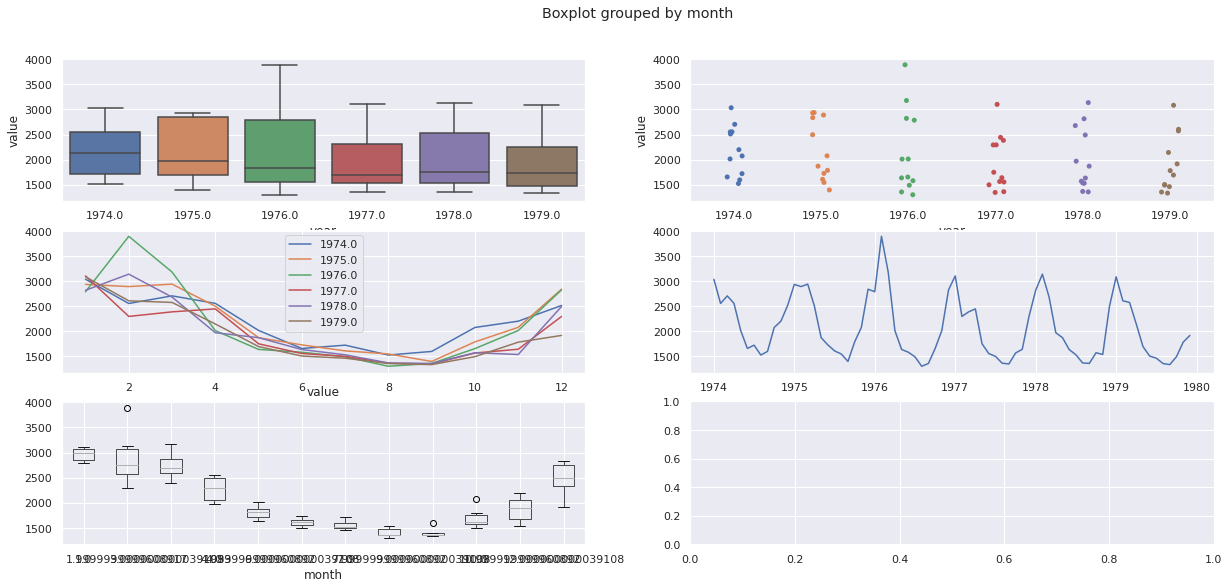

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(9)

sns.boxplot(x="year", y="value", data=deaths, ax=ax1[0])
sns.stripplot(x="year", y="value", data=deaths, ax=ax1[1])

for name, group in deaths.groupby(["year"]):
  ax2[0].plot(group["month"], group["value"], label=name)
ax2[0].legend()

ax2[1].plot(deaths["time"], deaths["value"])

# sns.boxplot(x=deaths["month"], deaths["value"])
deaths.boxplot(column="value", by="month", ax=ax3[0])


From the upper row we see that there is a slow downward trend over the years. </br> If we were to fit the linear model $value$ ~ $time$, it would've completely ignored the seasonal trend. </br></br>
The lower row shows this trend: deaths are more numerous at the end and at the start of the year; that is, in winter. This may prompt us to predict the deaths for the next year by the deaths for the previous years. That is, in our model we'll base the response? on the previous observations. </br>
In other words, the model:
$$ y_t = \beta_0 + \beta_1y_{t-1} + \beta_{12}y_{t-12} + \beta_{13}y_{t-13} + \epsilon_{t}$$, where $t$ ranges over total months. </br>
This is an example of an autoregressive process. </br>
The response depends on past values
of the response. </br>
The $y_{t-i}$ are called lagged variables </br>
The qualitative difference here is that the design matrix is now comprised of the according responses. </br>
In other words, the "labels" are now also the "features".

In [113]:
deaths["lag1"] = deaths["value"].shift(1)
deaths["lag12"] = deaths["value"].shift(12)
deaths["lag13"] = deaths["value"].shift(13)
deaths_lag = deaths.dropna()
deaths_lag.head(5)

,time,value,month,year,total_month,lag1,lag12,lag13
13,1975.083333,2889,2.0,1975.0,14.0,2933.0,2552.0,3035.0
14,1975.166667,2938,3.0,1975.0,15.0,2889.0,2704.0,2552.0
15,1975.250000,2497,4.0,1975.0,16.0,2938.0,2554.0,2704.0
16,1975.333333,1870,5.0,1975.0,17.0,2497.0,2014.0,2554.0
17,1975.416667,1726,6.0,1975.0,18.0,1870.0,1655.0,2014.0


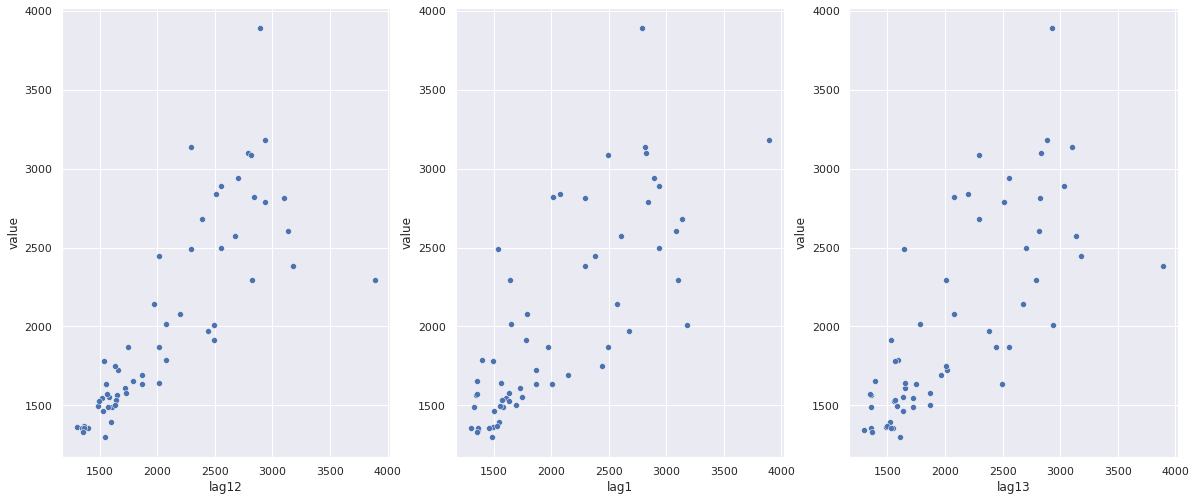

In [114]:
f, ax = plt.subplots(1, 3)
# f.set_figwidth(20)
sns.scatterplot(x="lag12", y="value", data=deaths_lag, ax=ax[0])
sns.scatterplot(x="lag1", y="value", data=deaths_lag, ax=ax[1])
sns.scatterplot(x="lag13", y="value", data=deaths_lag, ax=ax[2])

In [137]:
import faraway.utils

X = deaths_lag.loc[:, ["lag1", "lag12", "lag13"]]
X.insert(0, "Intercept", 1)
y = deaths_lag["value"]
lmod = sm.OLS(y, X).fit()
lmod.sumary()

           coefs  stderr tvalues pvalues
Intercept 93.444 161.748    0.58  0.5658
lag1       0.254   0.132    1.93  0.0590
lag12      0.544   0.114    4.77  0.0000
lag13      0.135   0.136    1.00  0.3237

n=59 p=4 Residual SD=328.824 R-squared=0.74


We could've also use the previous years information, that is, $lag24$ and $lag25$, but there is a tradeoff: every year we choose to account reduces the sample size by 13:

In [80]:
deaths.shape[0] - deaths_lag.shape[0]

13

So there is a tradeoff as to how large the sample size should be/how many predictors we'd like to include.

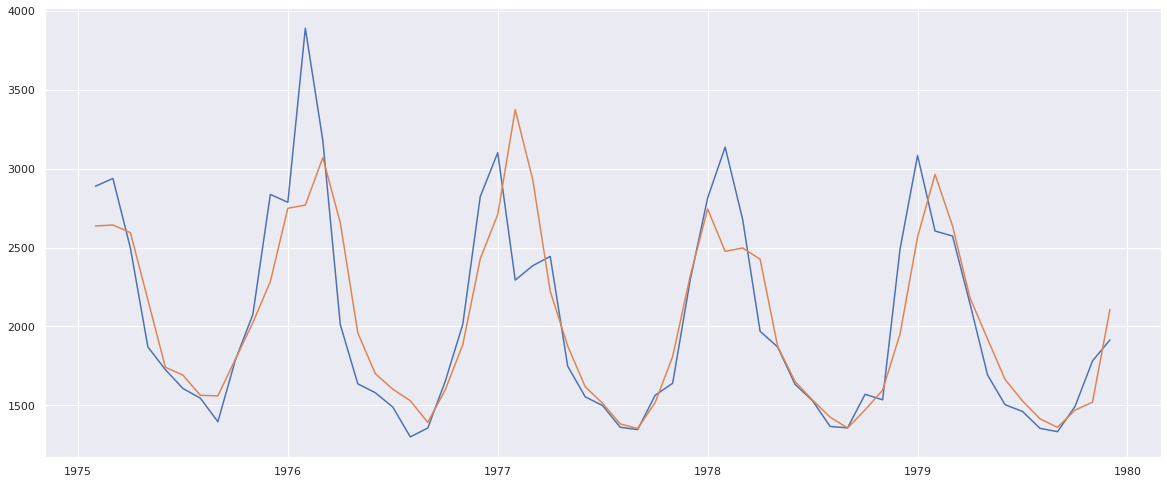

In [116]:
plt.plot(deaths_lag["time"], deaths_lag["value"])
plt.plot(deaths_lag["time"], lmod.predict(X))

In [155]:
x0_lag1 = deaths[(deaths["year"] == 1979) & (deaths["month"] == 12)]["value"].iloc[0]
x0_lag12 = deaths[(deaths["year"] == 1979) & (deaths["month"] == 1)]["value"].iloc[0]
x0_lag13 = deaths[(deaths["year"] == 1978) & (deaths["month"] == 12)]["value"].iloc[0]

# x0 = pd.DataFrame({
#     "Intercept": [1],
#     "lag1": [x0_lag1],
#     "lag12": [x0_lag12],
#     "lag13": [x0_lag13],
# })
x0 = pd.Series({
    "Intercept": 1,
    "lag1": x0_lag1,
    "lag12": x0_lag12,
    "lag13": x0_lag13,
})

lmod.get_prediction([x0_lag1, x0_lag12, x0_lag13]).summary_frame()

ValueError: ignored

In [123]:
x0_lag1 = deaths[(deaths["year"] == 1980) & (deaths["month"] == 1)]["value"]
x0_lag12 = deaths[(deaths["year"] == 1979) & (deaths["month"] == 2)]["value"]
x0_lag13 = deaths[(deaths["year"] == 1979) & (deaths["month"] == 1)]["value"]

x0 = pd.Series({
    "lag1": x0_lag1,
    "lag12": x0_lag12,
    "lag13": x0_lag13,
})
x0
deaths[(deaths["year"] == 1980)]

,time,value,month,year,total_month,lag1,lag12,lag13
